#### 손지우
참고사이트[1]: https://www.kaggle.com/faressayah/natural-language-processing-nlp-for-beginners

참고사이트[2]: https://www.kaggle.com/madz2000/simple-eda-with-data-cleaning-glove-98-accuracy

# Natural Language Processing Assignment: Spam Filter
## 1. Import necessary libs and datasets

In [1]:
#Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import urllib.request
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords

In [2]:
#Data Load
# urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

In [3]:
#Basic preprocessing
data = data[['v1', 'v2']]
data['v1'].replace(['ham','spam'], [0,1], inplace=True)
data.rename(columns={'v1':'isSpam', 'v2':'text'}, inplace=True)
print(f'Data Shape: {data.shape}')

Data Shape: (5572, 2)


In [4]:
#Check if data is imbalanced
print(data['isSpam'].value_counts())

0    4825
1     747
Name: isSpam, dtype: int64


In [5]:
#Data Check 
data.head()

,isSpam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.groupby('isSpam').describe()

text                                                               
       count unique                                                top freq
isSpam                                                                     
0       4825   4516                             Sorry, I'll call later   30
1        747    653  Please call our customer service representativ...    4

## 2. Preprocessing
### 텍스트 전처리함수입니다.

In [7]:
def cleanText(readData):
    
    #특수문자 제거
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\\‘|\(\)\[\]\<\>`\'…》å£û÷õ;]', '', readData)
    
    #소문자 처리
    text = text.lower()
    
    #불용어 처리 & 한글자 제거
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure', 'dun']
    text = ' '.join([word for word in text.split() if (word not in STOPWORDS) and (len(word) != 1)])
        
    return text

In [8]:
def tokenize(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j)
    return words

In [9]:
data['cleanText'] = data.text.apply(cleanText)

In [10]:
data.head(10)

,isSpam,text,cleanText
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...
3,0,U dun say so early hor... U c already then say...,say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
5,1,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling weeks word back id like fu...
6,0,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,0,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,1,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,1,Had your mobile 11 months or more? U R entitle...,mobile 11 months entitled update latest colour...


In [11]:
corpus = tokenize(data.cleanText)
corpus[:5] #check

['go', 'jurong', 'point', 'crazy', 'available']

## 3. Build Vocabulary

In [12]:
def build_vocab(n, corpus=corpus, graph=False):
    
    #Count
    counter = Counter(corpus)
    most_common = counter.most_common(n-2) #0: padding_idx, 1: unk_idx이기 때문에 2개 적게!
    most_common = dict(most_common)
    
    #Make Dictionary
    vocab = {}
    vocab['padding_idx'] = 0
    vocab['unk_idx'] = 1
    for idx, token in enumerate(most_common.keys()):
        vocab[token] = idx+2
        
    #Graph
    if graph == True:
        sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))
        plt.title('Top {} Vocab'.format(n-2))
        plt.show()

    return vocab

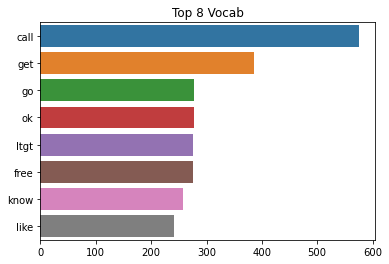

{'padding_idx': 0,
 'unk_idx': 1,
 'call': 2,
 'get': 3,
 'go': 4,
 'ok': 5,
 'ltgt': 6,
 'free': 7,
 'know': 8,
 'like': 9}

In [13]:
#example
build_vocab(10, graph=True)

In [14]:
#2000개 단어로 해보기
vocab = build_vocab(2000)

## 4. To Tensor

### toTensor
#### 토큰들을 텐서로 바꿔주는 함수입니다.

In [15]:
def toTensor(max_len, cleanText):
    text_num = len(cleanText)
    tch_big = torch.empty(text_num, max_len, dtype=torch.long)
    
    for idx, txt in enumerate(cleanText):
        token = txt.split()
        tch = torch.zeros(max_len)
        bow = []
        
        for word in token:
            if word in vocab.keys():
                bow.append(vocab[word])
            else:
                bow.append(1) # 1: unk_idx
        
        for i in range(len(bow)):
            if i < max_len:
                tch[i] = bow[i]
        
        tch_big[idx] = tch
    
    return tch_big

In [16]:
toTensor(10, data.cleanText).shape

torch.Size([5572, 10])

In [17]:
toTensor(10, data.cleanText)

tensor([[   4,    1,  663,  ...,  246, 1103,    1],
        [   5,  206, 1256,  ...,    0,    0,    0],
        [   7,  340,  618,  ...,  496, 1682,    1],
        ...,
        [   1, 1099,    1,  ...,    0,    0,    0],
        [ 384,    1,    1,  ...,   99,  377,  107],
        [   1,  361,  157,  ...,    0,    0,    0]])

## 5. Train-Test Split

In [18]:
def train(data, vocab_size=2000, max_len=20):
    data['cleanText'] = data.text.apply(cleanText)
    corpus = tokenize(data.cleanText)
    vocab = build_vocab(vocab_size)
    X, y = toTensor(max_len, data.cleanText), data.isSpam
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, test_size=0.1)
    
    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = train(data)

In [20]:
print(len(X_train), len(X_test))

5014 558


## 6. Evaluation

## 6-1. Logistic Regression

In [21]:
def logRegEval(X_test, y_test, k=40):
    
    #Logistic Regression 모델 설계
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    
    #40개의 Test sample 추출
    idx = random.sample(range(len(y_test)), k=k)
    indices = torch.tensor(idx)
    sample_X = torch.index_select(X_test, 0, indices)
    sample_y = y_test.reset_index(drop=True)[idx]
    
    #예측하기
    y_pred_class = logreg.predict(sample_X)
    y_pred_prob = logreg.predict_proba(sample_X)[:, 1]
    
    #평가하기
    accuracy = metrics.accuracy_score(sample_y, y_pred_class)
    auc = metrics.roc_auc_score(sample_y, y_pred_prob)
    
    print('< Logistic Regression >')
    print('Accuracy:',round(accuracy,4))
    print('AUC:', round(auc,4))

In [22]:
logRegEval(X_test, y_test)

< Logistic Regression >
Accuracy: 0.825
AUC: 0.8701


## 6-2. Attention
- 참고사이트: https://wikidocs.net/48920
- [예비참고사이트](https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/)

In [23]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import tensorflow as tf
import os

In [24]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [25]:
#X를 tensor에서 array로 수정함
X, y = toTensor(20, data.cleanText), data['isSpam']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, random_state=0, stratify=y, test_size=0.1)

In [26]:
def attentionEval(X_test, y_test, k=40, max_len = 20, vocab_size = 2000, epochs=10, show_progress=0, graph=False, heatmap=False):
        
    #입력층과 임베딩층 설계
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)
    
    #양방향 LSTM 설계
    lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences) #첫번째 층
    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm) #두번째 층
    
    #순방향&역방향 LSTM 연결해주기(concatenate)
    state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
    state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
    
    #Attention 모델 사용
    attention = BahdanauAttention(64) # 가중치 크기 정의
    context_vector, attention_weights = attention(lstm, state_h)
    
    #모델 구성하기
    dense1 = Dense(20, activation="relu")(context_vector)
    dropout = Dropout(0.5)(dense1)
    output = Dense(1, activation="sigmoid")(dropout)
    model = Model(inputs=sequence_input, outputs=output)
    
    #모델 엮기
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()]) #accuracy & AUC
    
    #모델 학습시키기 (show_progress=1이면, 진행상황 보여주기)
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = 256, validation_data=(X_test, y_test), verbose=show_progress)
    
    #40개의 Test sample 추출하기
    idx = random.sample(range(len(y_test)), k=k)
    sample_X = X_test[idx]
    sample_y = np.array(y_test)[idx]

    #평가하기
    accuracy, auc = model.evaluate(X_test, y_test, verbose=show_progress)[1:3]
    sample_accuracy, sample_auc = model.evaluate(sample_X, sample_y, verbose=show_progress)[1:3]
    
    print('< Attention >')
    print("Accuracy:", accuracy)
    print("AUC:", auc)
    print('\n')
    print('40개 Sample Accuracy:', sample_accuracy)
    print('40개 Sample AUC', sample_auc)
    
    if graph == True:
        epochs_ = [i for i in range(epochs)]
        train_acc = history.history['accuracy']
        train_loss = history.history['loss']
        val_acc = history.history['val_accuracy']
        val_loss = history.history['val_loss']

        fig , ax = plt.subplots(1,2)
        fig.set_size_inches(20,10)
        ax[0].plot(epochs_ , train_acc , 'go-' , label = 'Training Accuracy')
        ax[0].plot(epochs_ , val_acc , 'ro-' , label = 'Testing Accuracy')
        ax[0].set_title('Training & Testing Accuracy')
        ax[0].legend()
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Accuracy")

        ax[1].plot(epochs_ , train_loss , 'go-' , label = 'Training Loss')
        ax[1].plot(epochs_ , val_loss , 'ro-' , label = 'Testing Loss')
        ax[1].set_title('Training & Testing Loss')
        ax[1].legend()
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Loss")
        plt.show()
    
    if heatmap == True:
        pred_tmp = model.predict(X_test)
        pred = []
        for i in range(len(pred_tmp)):
            pred.append(round(pred_tmp[i][0]))

        cm = metrics.confusion_matrix(y_test, pred)
        cm = pd.DataFrame(cm, index = ['Not Spam','Spam'], columns = ['Not Spam','Spam'])
        plt.figure(figsize = (10,10))
        sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,
                    fmt='' , xticklabels = ['Not Spam','Spam'] , yticklabels = ['Not Spam','Spam'])
        plt.show()

< Attention >
Accuracy: 0.9749103784561157
AUC: 0.9669564366340637


40개 Sample Accuracy: 0.9750000238418579
40개 Sample AUC 1.0


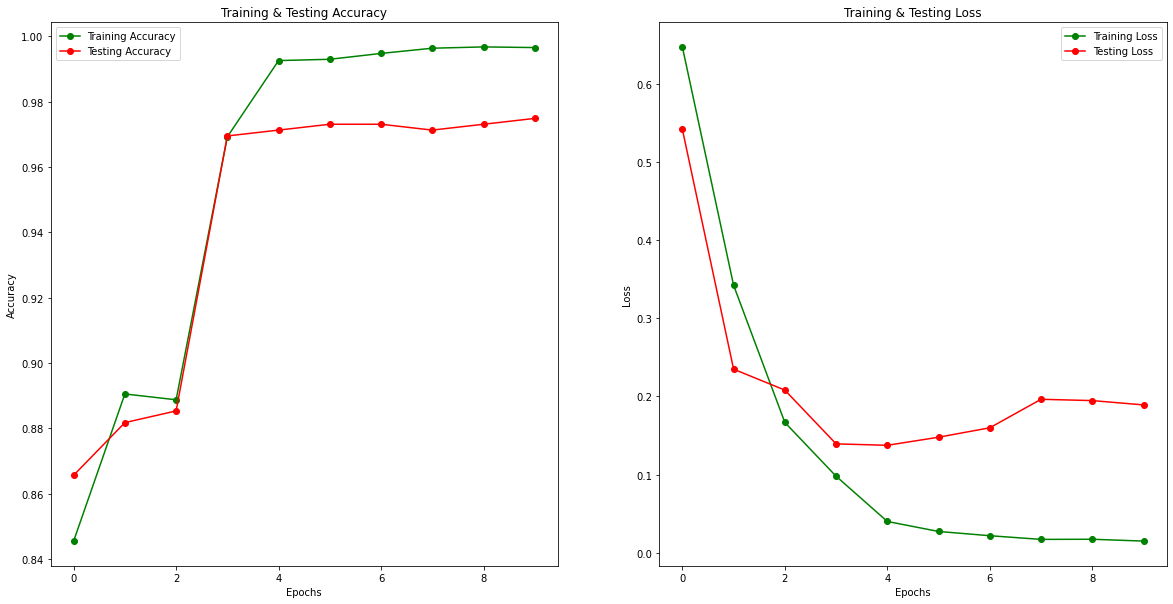

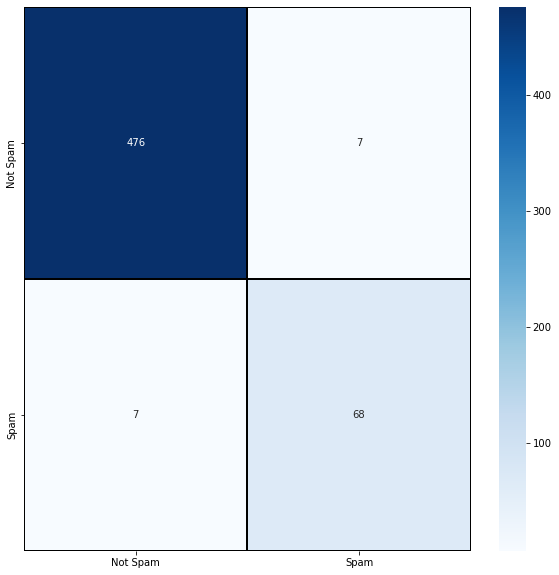

In [27]:
attentionEval(X_test, y_test, graph=True, heatmap=True)